In [23]:
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay
import joblib
import json
from datetime import datetime

# Pastas de saída
MODEL_DIR = "../Treino/models"
RESULTS_DIR = "../Treino/results"
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

In [9]:
df = pd.read_csv('../Análise/players_prepared.csv')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
df.head()

,player_positions,overall,potential,age,height_cm,weight_kg,preferred_foot,weak_foot,skill_moves,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,main_position,secondary_position,macro_position,macro_position_secondary,macro_position_enc,main_position_enc,secondary_position_enc,feat_offensive_index,feat_defensive_index,feat_technical_index,feat_speed_index,feat_stamina_strength_ratio,feat_attack_defense_ratio,feat_shooting_passing_ratio,feat_aerial_ability,feat_composure_aggression_ratio,feat_mentality_index,feat_reaction_positioning_avg,feat_vision_passing_combo,feat_bmi,feat_power_index,feat_lightweight_flag,feat_lateral_score,feat_centreback_score,feat_defensive_mid_score,feat_central_mid_score,feat_winger_score,feat_striker_score,feat_attack_minus_defense,feat_pace_minus_shoot
0,"CAM, CM",90,94,22,186,75,1,4,4,80.0,86.0,83.0,90.0,78.0,85.0,66,88,75,90,77,91,73,68,89,91,81,80,83,91,83,86,85,94,80,87,85,82,91,90,74,90,77,79,77,CAM,CM,Midfielder,Midfielder,1,0,3,86.333333,81.5,90.25,80.5,1.175000,1.059305,1.036145,80.0,1.058824,88.25,91.0,89.666667,21.678807,86.25,0,80.000000,80.333333,89.00,90.000000,79.25,83.00,4.833333,-5.5
1,"CM, CDM, RB",89,90,26,182,74,1,4,3,88.0,84.0,84.0,84.0,83.0,85.0,78,80,63,88,78,84,76,69,88,88,84,92,77,89,68,91,82,93,82,91,81,86,86,86,59,84,82,87,86,CM,CDM,Midfielder,Midfielder,1,3,2,84.000000,84.0,86.50,88.0,1.134146,1.000000,1.000000,72.5,1.037037,85.50,87.5,87.333333,22.340297,87.00,0,87.666667,85.000000,88.25,86.000000,84.50,78.75,0.000000,4.0
2,"CDM, RB, CM",89,89,30,177,75,1,4,3,72.0,74.0,89.0,84.0,83.0,79.0,92,68,72,89,69,82,85,79,92,86,75,70,83,89,84,78,77,92,69,83,89,85,78,86,71,86,82,86,85,CDM,RB,Midfielder,Defender,1,2,8,82.333333,81.0,86.25,72.5,1.333333,1.016461,0.831461,74.5,0.966292,83.75,83.5,89.000000,23.939481,79.00,0,84.666667,80.000000,88.00,87.000000,80.25,73.25,1.333333,-1.5
3,"RB, RM",89,90,26,181,73,1,4,4,92.0,79.0,82.0,83.0,82.0,79.0,85,80,71,86,74,82,78,80,73,85,89,95,81,90,78,82,84,95,72,77,77,85,84,78,68,84,82,85,79,RB,RM,Defender,Winger,0,7,9,81.333333,80.5,83.00,92.0,1.319444,1.010352,0.963415,77.5,1.090909,82.75,87.0,79.000000,22.282592,83.25,0,91.666667,80.666667,86.00,82.666667,88.00,76.50,0.833333,13.0
4,CM,87,87,28,175,68,1,4,3,80.0,78.0,84.0,86.0,81.0,76.0,79,77,60,89,80,84,79,67,87,87,82,78,91,91,88,80,75,89,66,79,87,85,84,85,73,88,80,85,80,CM,NaN,Midfielder,NaN,1,3,7,82.666667,78.5,86.75,80.0,1.348485,1.053079,0.928571,67.5,1.011494,85.50,87.5,87.000000,22.204082,77.50,1,82.000000,78.666667,87.00,87.333333,81.25,72.00,4.166667,2.0


In [10]:
df.dtypes

player_positions                    object
overall                              int64
potential                            int64
age                                  int64
height_cm                            int64
weight_kg                            int64
preferred_foot                       int64
weak_foot                            int64
skill_moves                          int64
pace                               float64
shooting                           float64
passing                            float64
dribbling                          float64
defending                          float64
physic                             float64
attacking_crossing                   int64
attacking_finishing                  int64
attacking_heading_accuracy           int64
attacking_short_passing              int64
attacking_volleys                    int64
skill_dribbling                      int64
skill_curve                          int64
skill_fk_accuracy                    int64
skill_long_

In [11]:
df.isna().sum()

player_positions                      0
overall                               0
potential                             0
age                                   0
height_cm                             0
weight_kg                             0
preferred_foot                        0
weak_foot                             0
skill_moves                           0
pace                                  0
shooting                              0
passing                               0
dribbling                             0
defending                             0
physic                                0
attacking_crossing                    0
attacking_finishing                   0
attacking_heading_accuracy            0
attacking_short_passing               0
attacking_volleys                     0
skill_dribbling                       0
skill_curve                           0
skill_fk_accuracy                     0
skill_long_passing                    0
skill_ball_control                    0


In [43]:
# colunas alvo e colunas de feature
targets = ['main_position_enc', 'macro_position_enc', 'secondary_position_enc']
drop_cols = ['player_positions', 'main_position', 'secondary_position',
             'macro_position', 'macro_position_secondary',
             'player_positions'] + targets  # remove targets e strings

X = df.select_dtypes(include=[np.number]).copy()
X = X.drop(columns=[c for c in drop_cols if c in X.columns], errors='ignore')

# Escolha do target
y = df['main_position_enc']

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("X shape:", X.shape, "X_train:", X_train.shape, "X_test:", X_test.shape)
print("y distribution (train):\n", y_train.value_counts(normalize=True))

X shape: (16343, 66) X_train: (13074, 66) X_test: (3269, 66)
y distribution (train):
 main_position_enc
1     0.203534
10    0.155041
3     0.135460
2     0.087655
7     0.087043
4     0.083678
0     0.069604
5     0.065091
8     0.062184
9     0.026618
6     0.024094
Name: proportion, dtype: float64


In [44]:
X.dtypes

overall                              int64
potential                            int64
age                                  int64
height_cm                            int64
weight_kg                            int64
preferred_foot                       int64
weak_foot                            int64
skill_moves                          int64
pace                               float64
shooting                           float64
passing                            float64
dribbling                          float64
defending                          float64
physic                             float64
attacking_crossing                   int64
attacking_finishing                  int64
attacking_heading_accuracy           int64
attacking_short_passing              int64
attacking_volleys                    int64
skill_dribbling                      int64
skill_curve                          int64
skill_fk_accuracy                    int64
skill_long_passing                   int64
skill_ball_

In [45]:
label_map = dict(zip(df["main_position_enc"], df["main_position"]))

y_pred = rf.predict(X_test)
target_names = [label_map[i] for i in sorted(label_map.keys())]

# Lembrando que as classes estão organizadas dessa forma
mapping = df[['main_position_enc','main_position']].drop_duplicates().sort_values('main_position_enc')
print(mapping.reset_index(drop=True))

    main_position_enc main_position
0                   0           CAM
1                   1            CB
2                   2           CDM
3                   3            CM
4                   4            LB
5                   5            LM
6                   6            LW
7                   7            RB
8                   8            RM
9                   9            RW
10                 10            ST


In [46]:
# Treinamento do Modelo
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,                # limita a profundidade
    min_samples_split=5,         # força splits com mais amostras
    min_samples_leaf=3,          # evita folhas pequenas
    max_features='sqrt',         # usa subset de features em cada árvore
    bootstrap=True,              # padrão, mas garante diversidade
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)

# salvar modelo provisório
model_path = os.path.join(MODEL_DIR, f"model_baseline_rf_{datetime.now().strftime('%Y%m%d_%H%M')}.pkl")
joblib.dump(rf, model_path)
print("Modelo salvo em:", model_path)

Modelo salvo em: ../Treino/models\model_baseline_rf_20251112_1949.pkl


In [47]:
# Avaliação
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

print("Train accuracy:", accuracy_score(y_train, y_train_pred))
print("Test  accuracy:", accuracy_score(y_test, y_test_pred))
print("\nF1-macro (test):", f1_score(y_test, y_test_pred, average='macro'))

print("\nClassification report (test):")
print(classification_report(y_test, y_test_pred, target_names=target_names, zero_division=0))

Train accuracy: 0.8840446688083219
Test  accuracy: 0.7301927194860813

F1-macro (test): 0.5797098314506545

Classification report (test):
              precision    recall  f1-score   support

         CAM       0.51      0.52      0.51       227
          CB       0.91      0.94      0.92       665
         CDM       0.65      0.63      0.64       287
          CM       0.65      0.81      0.72       443
          LB       0.89      0.85      0.87       273
          LM       0.37      0.40      0.39       213
          LW       1.00      0.01      0.03        79
          RB       0.79      0.81      0.80       285
          RM       0.46      0.31      0.37       203
          RW       0.47      0.16      0.24        87
          ST       0.85      0.94      0.90       507

    accuracy                           0.73      3269
   macro avg       0.68      0.58      0.58      3269
weighted avg       0.73      0.73      0.71      3269



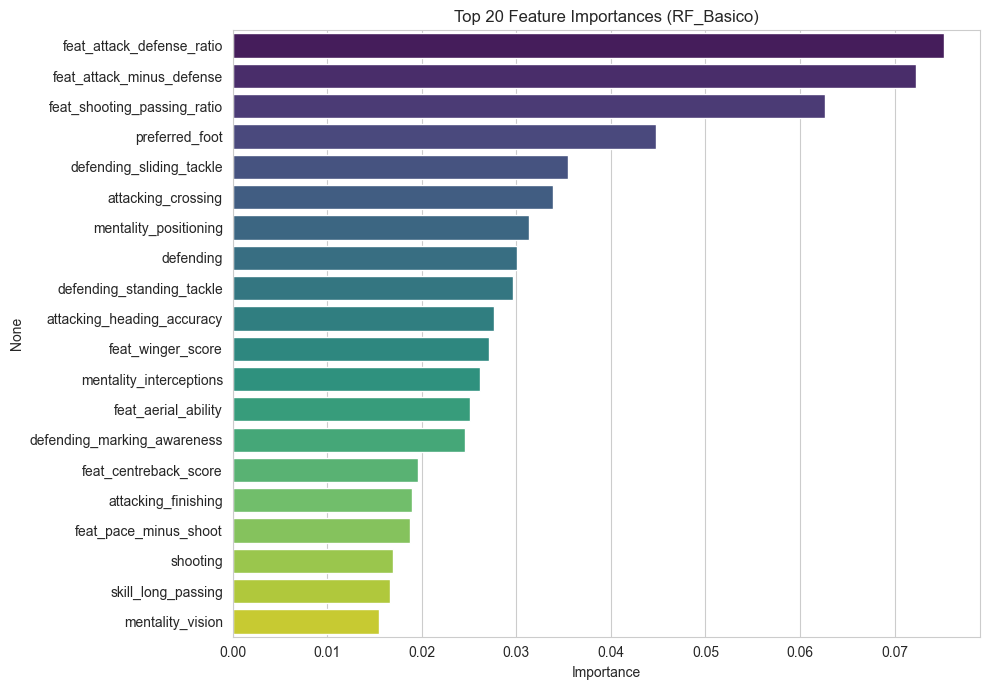

Feature importances salvas em: ../Treino/results\feature_importances_top20.png


In [49]:
sns.set_style('whitegrid')

# Recalcula predições caso necessário
y_test_pred = rf.predict(X_test)

# Série de importâncias
feat_names = X.columns.tolist()
importances = rf.feature_importances_
fi = pd.Series(importances, index=feat_names).sort_values(ascending=False).head(20)

plt.figure(figsize=(10,7))
sns.barplot(x=fi.values, y=fi.index, palette="viridis")
plt.title("Top 20 Feature Importances (RF_Basico)")
plt.xlabel("Importance")
plt.tight_layout()

# Salvar figura
fi_path = os.path.join(RESULTS_DIR, "feature_importances_top20.png")
plt.savefig(fi_path, bbox_inches='tight', dpi=150)
plt.show()

print("Feature importances salvas em:", fi_path)

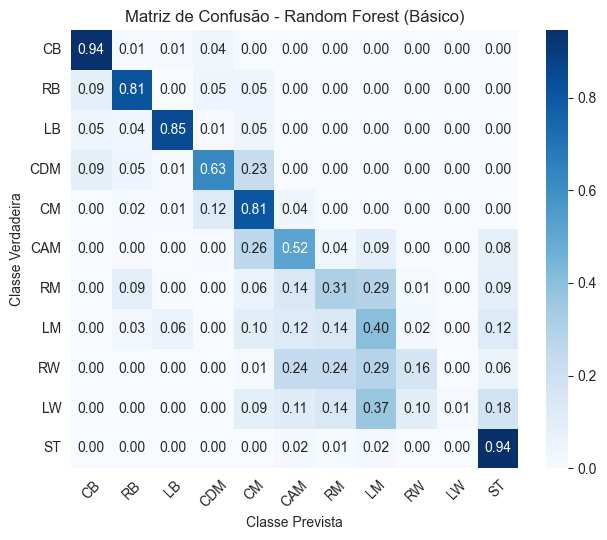

Matriz de confusão salva em: ../Treino/results\confusion_matrix_RF_basico.png


In [55]:
custom_order = ["CB", "RB", "LB", "CDM", "CM", "CAM", "RM", "LM", "RW", "LW", "ST"]
mapping_df = df[['main_position_enc','main_position']].drop_duplicates().sort_values('main_position_enc')
label_map = dict(zip(mapping_df['main_position_enc'], mapping_df['main_position']))
reverse_label_map = {v: int(k) for k, v in label_map.items()}

order_indices = [reverse_label_map[pos] for pos in custom_order if pos in reverse_label_map]

# Matriz Confusão
cm = confusion_matrix(y_test, y_test_pred, labels=order_indices, normalize='true')

display_labels = [pos for pos in custom_order if pos in reverse_label_map]

plt.figure(figsize=(6.5,5.5))
ax = sns.heatmap(
    cm,
    annot=True, fmt=".2f",
    cmap="Blues",
    xticklabels=display_labels,
    yticklabels=display_labels,
    cbar=True,
    linewidths=0,  # <<< remove linhas
    linecolor=None
)
plt.title("Matriz de Confusão - Random Forest (Básico)")
plt.xlabel("Classe Prevista")
plt.ylabel("Classe Verdadeira")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

cm_path = os.path.join(RESULTS_DIR, "confusion_matrix_RF_basico.png")
plt.savefig(cm_path, bbox_inches='tight', dpi=150)
plt.show()

print("Matriz de confusão salva em:", cm_path)

In [56]:
# Salvar label_map (enc -> label)
label_map_path = os.path.join(RESULTS_DIR, "label_map.json")
with open(label_map_path, "w") as f:
    json.dump({str(k): v for k, v in label_map.items()}, f, indent=2, ensure_ascii=False)
print("label_map salvo em:", label_map_path)

# Salvar lista de features que o modelo usa (ordem)
features_path = os.path.join(RESULTS_DIR, "features_used.json")
with open(features_path, "w") as f:
    json.dump(list(X.columns), f, indent=2)
print("Lista de features salva em:", features_path)

label_map salvo em: ../Treino/results\label_map.json
Lista de features salva em: ../Treino/results\features_used.json
